In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [2]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [3]:
CLASS_NAMES= ['healthy', 'mild', 'moderate', 'severe']
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
NUM_CLASSES = len(CLASS_NAMES)

# **ResNET**

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
#load data
data_x = np.load('fractal_reshapeRecPlot_data_x_aumentated_normalized.npy') #images
data_y = np.load('fractal_reshapeRecPlot_data_y_aumentated_normalized.npy') #labels
TOTAL_IMAGES = len(data_y)
print("TOTAL_IMAGES = ", TOTAL_IMAGES)

TOTAL_IMAGES =  1184


In [6]:
# scale pixels
def prep_pixels(train, test, validation):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    validation_norm = validation.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    validation_norm = validation_norm / 255.0
    # return normalized images
    return train_norm, test_norm, validation_norm

# **Splitting data in train - validation - test**

In [7]:
#percentage of the dataset which will be on TRAIN - TEST - VALIDATION
TRAIN_PERCENTAGE = 0.8
TEST_PERCENTAGE = 0.1
VALIDATION_PERCENTAGE = 0.1

In [8]:
train_size = int(TRAIN_PERCENTAGE * TOTAL_IMAGES)
test_size = int(TEST_PERCENTAGE * TOTAL_IMAGES)
validation_size = int(VALIDATION_PERCENTAGE * TOTAL_IMAGES)

In [9]:
train_x = data_x[:train_size]
train_y = data_y[:train_size]
data_x = data_x[train_size:]
data_y = data_y[train_size:]

test_x = data_x[:test_size]
test_y = data_y[:test_size]
data_x = data_x[test_size:]
data_y = data_y[test_size:]

validation_x = data_x #all the remainder we can let on validation
validation_y = data_y
del data_x
del data_y

In [10]:
print("train_size = ", len(train_y))
print("test_size = ", len(test_y))
print("validation_size = ", len(validation_y))

train_size =  947
test_size =  118
validation_size =  119


In [11]:
train_x, test_x, validation_x = prep_pixels(train_x, test_x, validation_x)

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from IPython.display import SVG
import scipy.misc

In [14]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import EfficientNetB5
# from tensorflow.keras.applications import EfficientNetB6
# from tensorflow.keras.applications import EfficientNetB7
# from tensorflow.keras.applications import *

In [15]:
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [16]:
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMG_HEIGHT,IMG_WIDTH, CHANNELS),
    pooling=None,
    classes=NUM_CLASSES,
   # classifier_activation="softmax",
#    **kwargs
)

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers

new_model = models.Sequential()
new_model.add(model)
#3rd conv layer
new_model.add(tf.keras.layers.Conv2D(32, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#4th conv layer
new_model.add(tf.keras.layers.Conv2D(64, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#Flatten Layer
new_model.add(tf.keras.layers.Flatten())

new_model.add(tf.keras.layers.Dense(128, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.Dropout(0.2))
#new_model.add(tf.keras.layers.l2( l=0.01))
#new_model.add(layers.GlobalAveragePooling2D())
#output Dense Layer
new_model.add(tf.keras.layers.Dense(NUM_CLASSES))
new_model.add(tf.keras.layers.Activation('softmax'))
adam = tf.keras.optimizers.Adam(lr=0.001)


C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 32)          589856    
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4, 4, 32)          0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          1

In [19]:
epochs = 100

#compila e treina o modelo com os dados carregados
new_model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=adam)
model_trained = new_model.fit(train_x, train_y,epochs=epochs,verbose=2,validation_data=(validation_x, validation_y),shuffle=False)

Epoch 1/100
30/30 - 22s - loss: 1.8791 - acc: 0.5174 - val_loss: 3.8391 - val_acc: 0.3025 - 22s/epoch - 750ms/step
Epoch 2/100
30/30 - 8s - loss: 1.3889 - acc: 0.7191 - val_loss: 2.5242 - val_acc: 0.2689 - 8s/epoch - 259ms/step
Epoch 3/100
30/30 - 8s - loss: 1.1017 - acc: 0.8163 - val_loss: 2.1207 - val_acc: 0.2689 - 8s/epoch - 259ms/step
Epoch 4/100
30/30 - 8s - loss: 0.8807 - acc: 0.8912 - val_loss: 2.3649 - val_acc: 0.1849 - 8s/epoch - 260ms/step
Epoch 5/100
30/30 - 8s - loss: 0.8567 - acc: 0.8807 - val_loss: 5.8071 - val_acc: 0.1849 - 8s/epoch - 261ms/step
Epoch 6/100
30/30 - 8s - loss: 0.7419 - acc: 0.8965 - val_loss: 13.7433 - val_acc: 0.1849 - 8s/epoch - 260ms/step
Epoch 7/100
30/30 - 8s - loss: 0.5664 - acc: 0.9440 - val_loss: 3.6640 - val_acc: 0.1849 - 8s/epoch - 260ms/step
Epoch 8/100
30/30 - 8s - loss: 0.4903 - acc: 0.9504 - val_loss: 3.4936 - val_acc: 0.2437 - 8s/epoch - 262ms/step
Epoch 9/100
30/30 - 8s - loss: 0.4935 - acc: 0.9324 - val_loss: 3.6442 - val_acc: 0.2437 - 8s

Epoch 73/100
30/30 - 8s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9916 - 8s/epoch - 268ms/step
Epoch 74/100
30/30 - 8s - loss: 9.3274e-04 - acc: 1.0000 - val_loss: 0.0349 - val_acc: 0.9916 - 8s/epoch - 268ms/step
Epoch 75/100
30/30 - 8s - loss: 9.1025e-04 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9916 - 8s/epoch - 268ms/step
Epoch 76/100
30/30 - 8s - loss: 8.1605e-04 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9916 - 8s/epoch - 268ms/step
Epoch 77/100
30/30 - 8s - loss: 8.2814e-04 - acc: 1.0000 - val_loss: 0.0413 - val_acc: 0.9916 - 8s/epoch - 268ms/step
Epoch 78/100
30/30 - 8s - loss: 8.3575e-04 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9916 - 8s/epoch - 269ms/step
Epoch 79/100
30/30 - 8s - loss: 8.2191e-04 - acc: 1.0000 - val_loss: 0.0464 - val_acc: 0.9916 - 8s/epoch - 269ms/step
Epoch 80/100
30/30 - 8s - loss: 7.9177e-04 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9916 - 8s/epoch - 269ms/step
Epoch 81/100
30/30 - 8s - loss: 7.4184e-04 - acc: 1.0000 - v

In [20]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [21]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [22]:
#print(getLayerIndexByName(new_model, 'flatten_1')) #just used to get the index of flatten layer

In [23]:
model_name = f'resnet50v2_reshapeRecPlot_baseline-holdout-{epochs}epochs_normalized_augmentated.npy'
new_model.save(model_name)

INFO:tensorflow:Assets written to: resnet50v2_reshapeRecPlot_baseline-holdout-100epochs_normalized_augmentated.npy\assets


INFO:tensorflow:Assets written to: resnet50v2_reshapeRecPlot_baseline-holdout-100epochs_normalized_augmentated.npy\assets


# **Random Forest - flatting**

In [24]:
new_model_rf = keras.Model(inputs=new_model.input, outputs=new_model.get_layer(index=9).output)
featureVector = new_model_rf.predict(train_x)

30/30 [==============================] - 3s 74ms/step


In [25]:
featureVector2 = new_model_rf.predict(test_x)

4/4 [==============================] - 1s 314ms/step


In [26]:
print(featureVector.shape)

(947, 64)


In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(featureVector,train_y)



RandomForestClassifier()

In [29]:
test_x.shape

(118, 128, 128, 3)

In [30]:
y_pred=clf.predict(featureVector2)

In [31]:
featureVector.shape

(947, 64)

In [32]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

Accuracy: 1.0


In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
clf = DecisionTreeClassifier(random_state=0)

# **Testes**

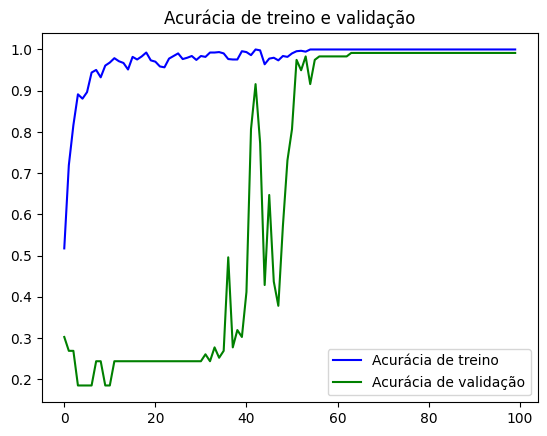

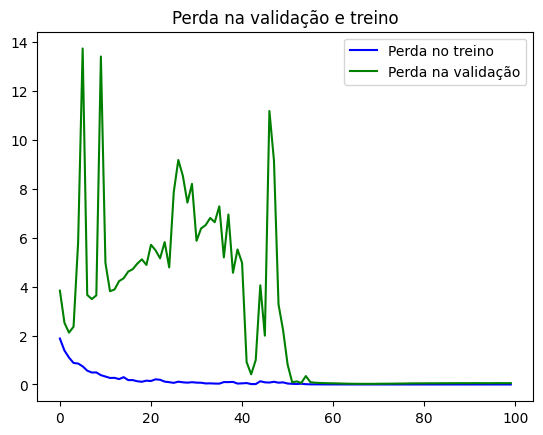

In [35]:
import matplotlib.pyplot as plt

accuracy = model_trained.history['acc']
val_accuracy = model_trained.history['val_acc']
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Acurácia de treino')
plt.plot(epochs, val_accuracy, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Perda no treino')
plt.plot(epochs, val_loss, 'g', label='Perda na validação')
plt.title('Perda na validação e treino')
plt.legend()
plt.show()

In [36]:
#avalia a fase de teste

model_loss, model_accuracy = new_model.evaluate(test_x, test_y, verbose=1)

#mostra o resultado
print('Test loss:', model_loss)
print('Test accuracy:', model_accuracy)

4/4 [==============================] - 0s 75ms/step - loss: 4.2228e-04 - acc: 1.0000
Test loss: 0.0004222807474434376
Test accuracy: 1.0


In [37]:
model_loss, model_accuracy = new_model.evaluate(train_x, train_y, verbose=1)

30/30 [==============================] - 2s 79ms/step - loss: 3.1703e-04 - acc: 1.0000


In [38]:
print('Test loss:', model_loss)
print('Test accuracy:', model_accuracy)

Test loss: 0.0003170255513396114
Test accuracy: 1.0


In [39]:
model_loss, model_accuracy = new_model.evaluate(validation_x, validation_y, verbose=1)

4/4 [==============================] - 0s 74ms/step - loss: 0.0550 - acc: 0.9916


In [40]:
print(0.9916*len(validation_y))

118.0004


In [41]:
print(len(set(test_y)))

4


In [42]:
print('Test loss:', model_loss)
print('Test accuracy:', model_accuracy)

Test loss: 0.05504802241921425
Test accuracy: 0.9915966391563416


In [52]:
#faz a predição das imagens

from tensorflow.keras.utils import to_categorical

pred = new_model.predict(validation_x, verbose=0)

pred_probs = np.argmax(pred,axis=1)

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [54]:
cm = confusion_matrix(validation_y, pred_probs)

In [55]:
#gera os valores de falso positivo, falso negativo, verdadeiro positivo e verdadeiro negativo
fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)

f1score = f1_score(validation_y, pred_probs, average='weighted')
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy    = (tp + tn) / (tp + tn + fp + fn)
precision   = tp / (tp + fp)

print("fp:", fp)
print("fn:", fn)
print("tp:", tp)
print("tn:", tn)
print("F1 Score:", f1score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:  ", precision)
print("Accuracy:   ", accuracy)

fp: [0 0 0 1]
fn: [0 1 0 0]
tp: [32 28 36 22]
tn: [87 90 83 96]
F1 Score: 0.9916162956410633
Sensitivity: [1.         0.96551724 1.         1.        ]
Specificity: [1.         1.         1.         0.98969072]
Precision:   [1.         1.         1.         0.95652174]
Accuracy:    [1.         0.99159664 1.         0.99159664]
